In [1]:
%matplotlib inline
import sys
sys.path.append("..")

import os
import torch 
import numpy as np
from skimage import io
from pathlib import Path
import albumentations as A
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from skimage.transform import resize
from PIL import Image, ImageSequence
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2

from unet.datasets import ISBI_D
from unet.preprocessing import images_mean, images_std
from unet.models import UNet

ISBI_ = Path("../data/isbi")
BOWL_ = Path("../data/nuclei")
BRATS_ = Path("../data/brats13")
LITS_ = Path("../data/lits")
IMG_H, IMG_W = 256, 256

(30, 512, 512) (30, 512, 512)


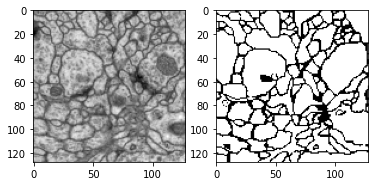

In [2]:
imgs_1 = io.imread(os.path.join(ISBI_, "train-volume.tif"))
masks_1 = io.imread(os.path.join(ISBI_, "train-labels.tif"))

print(imgs_1.shape, masks_1.shape)

for img,msk in zip(imgs_1, masks_1):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    break

In [5]:
# split and save ISBI dataset
img_count = imgs_1.shape[0]
val_count = int(img_count*0.2)

cwd = os.getcwd()
train_dir = os.path.join(ISBI_, "train"); #os.mkdir(train_dir)
val_dir = os.path.join(ISBI_, "val"); #os.mkdir(val_dir)

for x in range(img_count - val_count):
    ipath = os.path.join(train_dir, "images")
    os.makedirs(ipath, exist_ok=True)
    im = Image.fromarray(imgs_1[x])
    im.save(os.path.join(ipath, str(x) + ".png"))
    
    mpath = os.path.join(train_dir, "masks")
    os.makedirs(mpath, exist_ok=True)
    im = Image.fromarray(masks_1[x])
    im.save(os.path.join(mpath, str(x) + ".png"))
    
for x in range(1, val_count+1):
    ipath = os.path.join(val_dir, "images")
    os.makedirs(ipath, exist_ok=True)
    im = Image.fromarray(imgs_1[-x])
    im.save(os.path.join(ipath, str(x) + ".png"))
    
    mpath = os.path.join(val_dir, "masks")
    os.makedirs(mpath, exist_ok=True)
    im = Image.fromarray(masks_1[-x])
    im.save(os.path.join(mpath, str(x) + ".png"))

In [3]:
def visualize(image, mask):
    f, ax = plt.subplots(2, 1, figsize=(8, 8))

    ax[0].imshow(image, cmap="bone")
    ax[1].imshow(mask, cmap="bone")

In [4]:
train_path = os.path.join(ISBI_, "train")
val_path = os.path.join(ISBI_, "val")

augs = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.RandomBrightnessContrast(p=0.7),
    A.Flip(p=0.5),
    # A.GaussNoise(var_limit=20.0, p=0.5),
    A.ElasticTransform(p=0.5),
    A.GridDistortion(p=0.5), 
    A.Rotate(p=0.5),
    A.Normalize(mean=(0.485, ), std=(0.229, )),
    ToTensorV2()
], p=1)

train_d = ISBI_D(train_path, augs)
# img, mask = train_d.__getitem__(10)
# visualize(img.squeeze(0), mask)

train_dataloader = DataLoader(train_d, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 1, 256, 256])
Labels batch shape: torch.Size([1, 256, 256])


In [8]:
x = torch.Tensor(np.expand_dims(imgs_1, axis=1))/255
y = torch.Tensor(np.expand_dims(masks_1, axis=1))/255
y[y != 1.0] = 0


trans = transforms.Compose([transforms.Resize(256)])
x, y = trans(x), trans(y)

x_sub = torch.Tensor(np.expand_dims(x[0], axis=1))
y_sub = torch.Tensor(y[0])
y_sub[y_sub != 1.0] = 0

In [6]:
model = UNet(1, 1)
summary(model, (1, 572, 572))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]             640
              ReLU-2         [-1, 64, 572, 572]               0
            Conv2d-3         [-1, 64, 572, 572]          36,928
              ReLU-4         [-1, 64, 572, 572]               0
       Double_conv-5         [-1, 64, 572, 572]               0
         MaxPool2d-6         [-1, 64, 286, 286]               0
         Conv_down-7  [[-1, 64, 286, 286], [-1, 64, 572, 572]]               0
            Conv2d-8        [-1, 128, 286, 286]          73,856
              ReLU-9        [-1, 128, 286, 286]               0
           Conv2d-10        [-1, 128, 286, 286]         147,584
             ReLU-11        [-1, 128, 286, 286]               0
      Double_conv-12        [-1, 128, 286, 286]               0
        MaxPool2d-13        [-1, 128, 143, 143]               0
        Conv_down-14  [[

In [9]:
# Construct our model by instantiating the class defined above
model = UNet(1, 1)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for t in range(1):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model.forward(x_sub)

    # Compute and print loss
    loss = criterion(y_pred.squeeze(1), y_sub)
    #if t % 100 == 99:
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6744319200515747


In [15]:
y_pred.squeeze(1).size(), y_sub.size()

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

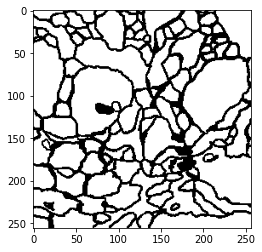

In [19]:
fig, _ = plt.subplots(1, 1)
img = y.numpy()[0][0]
img = resize(img, (256,256))
fig.axes[0].imshow(img, cmap='gray')
plt.show()

In [20]:
type(torch.empty(3, dtype=torch.long).random_(5))

torch.Tensor

In [11]:
# Source: https://discuss.pytorch.org/t/is-there-something-like-keras-utils-to-categorical-in-pytorch/5960/2
# Also check: https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9-L37
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

torch.Size([1, 256, 256])